In [2]:
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-2.0.1+cu118.html
!pip install -q torch-geometric
!pip install -q selfies
!pip install -q rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 4.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 50.1 MB/s eta 0:00:00


In [49]:
!wget -q https://raw.githubusercontent.com/hohyun312/molgen-tutorial/main/distributions.py
!wget -q https://raw.githubusercontent.com/hohyun312/molgen-tutorial/main/mol_env.py
!wget -q https://raw.githubusercontent.com/hohyun312/molgen-tutorial/main/models.py

# 1.1 Rdkit basics

**Installation**: `conda install -c conda-forge rdkit`


**RDKit docs**: https://www.rdkit.org/docs/GettingStartedInPython.html

In [3]:
import rdkit
from rdkit import Chem
import pandas as pd
import numpy as np

# check version
print("rdkit\t", rdkit.__version__)
print("pandas\t", pd.__version__)
print("numpy\t", np.__version__)

rdkit	 2023.03.3
pandas	 1.5.3
numpy	 1.23.5


## Key features

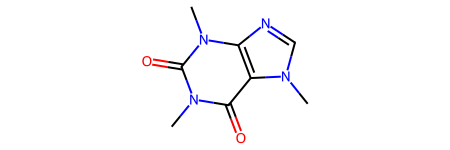

In [4]:
caffeine = "CN1C=NC2=C1C(=O)N(C(=O)N2C)C"
mol = Chem.MolFromSmiles(caffeine)
mol

In [5]:
# There could be multiple SMILES for one molecule.
canonical_smiles = Chem.MolToSmiles(mol)
canonical_smiles == caffeine

False

In [6]:
data = []
for atom in mol.GetAtoms():
    symbol = atom.GetSymbol()
    charge = atom.GetFormalCharge()
    impl_H = atom.GetNumImplicitHs()
    degree = atom.GetDegree()
    inring = atom.IsInRing()

    data.append([symbol, charge, impl_H, degree, inring])

pd.DataFrame(
    data,
    columns=["Symbol", "FormalCharge", "NumImplicitHs", "Degree", "IsInRing"]
)

,Symbol,FormalCharge,NumImplicitHs,Degree,IsInRing
0,C,0,3,1,False
1,N,0,0,3,True
2,C,0,1,2,True
3,N,0,0,2,True
4,C,0,0,3,True
5,C,0,0,3,True
6,C,0,0,3,True
7,O,0,0,1,False
8,N,0,0,3,True
9,C,0,0,3,True


In [7]:
data = []
for bond in mol.GetBonds():
    i = bond.GetBeginAtomIdx()
    j = bond.GetEndAtomIdx()
    bond_type = str(bond.GetBondType())

    data.append([i, j, bond_type])

pd.DataFrame(data, columns=["BeginAtomIdx", "EndAtomIdx", "BondType"])

,BeginAtomIdx,EndAtomIdx,BondType
0,0,1,SINGLE
1,1,2,AROMATIC
2,2,3,AROMATIC
3,3,4,AROMATIC
4,4,5,AROMATIC
5,5,6,AROMATIC
6,6,7,DOUBLE
7,6,8,AROMATIC
8,8,9,AROMATIC
9,9,10,DOUBLE


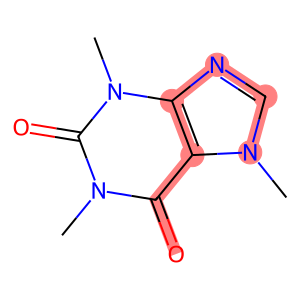

In [8]:
# Visualization
Chem.Draw.MolToImage(
    mol,
    highlightAtoms=[1, 2, 3, 4, 5],
    highlightBonds=[1, 2, 3, 4, 5, 6]
)

## Morgan fingerprint

<p style='text-align: center;'>
<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FPXIzC%2FbtsaER51rZk%2FuKSG15GVsnMC0GkK9D1rt0%2Fimg.png" width=500>
    <a href="https://biomadscientist.tistory.com/55">
        Img source
    </a>
</p>


In [9]:
# Get dataset
url = (
    'https://raw.githubusercontent.com'\
    '/gashawmg/HOMO-LUMO-Enegry-gap-Prediction/master/Orbital_Energies_input_data.csv'
)
dataset = pd.read_csv(url)
dataset.head()

,SMILES,Energygap
0,Cc1ccc(cc1)C(F)(F)F,197.749421
1,OC(=O)CCCCl,247.493942
2,CC(C)(Oc1ccc(CCNC(=O)c2ccc(Cl)cc2)cc1)C(=O)O,164.712327
3,Nc1ccc(Cl)c(Cl)c1,169.027707
4,C[C@@H](CCO)CCC=C(C)C,209.569808


In [10]:
# Transform smiles into RDKit mol representation
molecules = dataset.SMILES.apply(Chem.MolFromSmiles).to_numpy()
molecules

array([<rdkit.Chem.rdchem.Mol object at 0x78e01afb2ce0>,
       <rdkit.Chem.rdchem.Mol object at 0x78e01afb2e30>, ...,
       <rdkit.Chem.rdchem.Mol object at 0x78e01aea2ea0>], dtype=object)

In [11]:
from rdkit.Chem import AllChem
from rdkit import DataStructs

# Compute molecular descriptor
dataset_fps = [AllChem.GetMorganFingerprintAsBitVect(m, radius=3, nBits=2048) for m in molecules]
caffeine_fps = AllChem.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=2048)

# Compute Tanimoto similarities.
# Tanimoto similarity is similar to Jaccard similarity in molecular context.
scores = np.array(DataStructs.BulkTanimotoSimilarity(caffeine_fps, dataset_fps))
indices = np.argsort(scores)


dissimilar_molecules = molecules[indices[:10]]
similar_molecules = molecules[indices[-10::]]

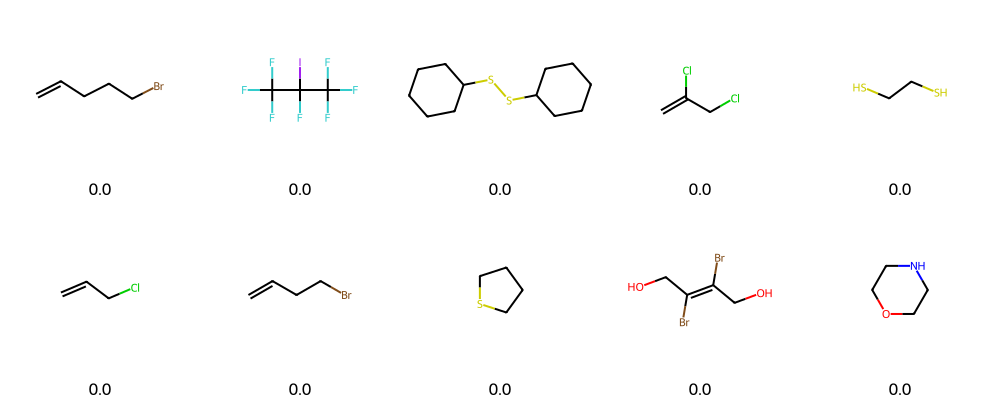

In [12]:
Chem.Draw.MolsToGridImage(
    dissimilar_molecules,
    molsPerRow=5,
    legends=[str(round(x, 4)) for x in scores[indices[:10]]]
)

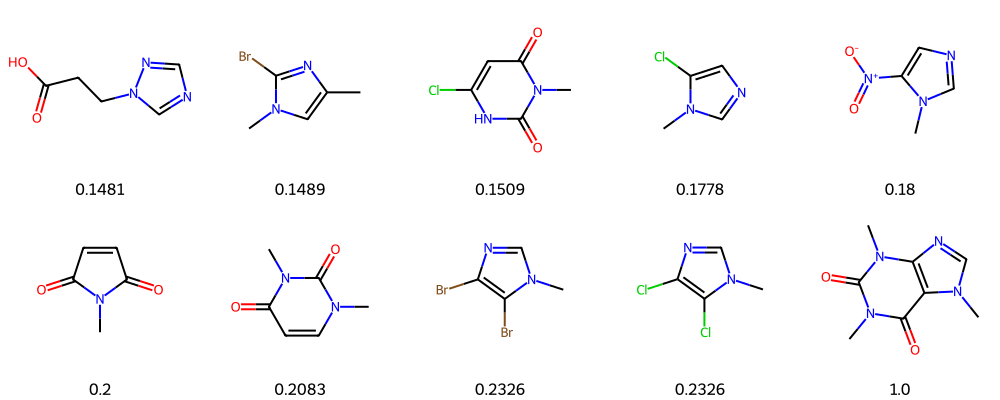

In [13]:
Chem.Draw.MolsToGridImage(
    similar_molecules,
    molsPerRow=5,
    legends=[str(round(x, 4)) for x in scores[indices[-10:]]]
)

## Edge case

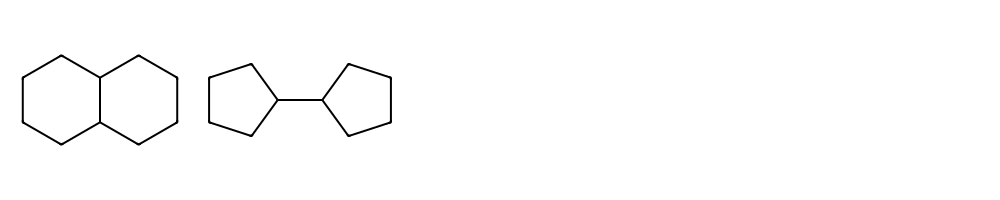

In [14]:
decalin = Chem.MolFromSmiles("C1CCC2CCCCC2C1")
bicyclopentyl  = Chem.MolFromSmiles("C1CCC(C1)C2CCCC2")

Chem.Draw.MolsToGridImage([decalin, bicyclopentyl], molsPerRow=5)

In [15]:
DataStructs.TanimotoSimilarity(
    AllChem.GetMorganFingerprintAsBitVect(decalin, radius=3, nBits=2048),
    AllChem.GetMorganFingerprintAsBitVect(bicyclopentyl, radius=3, nBits=2048)
)

1.0

## References

- datamol docs: https://docs.datamol.io/stable/
    
    `Datamol` is a python library to work with molecules. It's a layer built on top of RDKit and aims to be as light as possible.

---

- LAIDD: https://www.laidd.org/

    AI 신약개발 강의 플랫폼. RDKit에 대한 보다 자세한 설명은 물론, 신약개발에 필요한 전범위의 강의를 볼 수 있다.

# 1.2 PyG basics

In [16]:
import torch_geometric
import torch_geometric.nn as gnn
import torch_geometric.data as gd
from torch_geometric.utils import from_smiles

import torch
import torch.nn.functional as F
from torch import nn

import pandas as pd
import numpy as np
import rdkit
from rdkit import Chem

# check version
print("torch_geometric\t", torch_geometric.__version__)
print("torch\t", torch.__version__)
print("pandas\t", pd.__version__)
print("numpy\t", np.__version__)
print("rdkit\t", rdkit.__version__)

torch_geometric	 2.3.1
torch	 2.0.1+cu118
pandas	 1.5.3
numpy	 1.23.5
rdkit	 2023.03.3


## Data handling with `torch_geometric`

We show a simple example of an unweighted and undirected graph with three nodes and four edges. Each node contains exactly one feature:

<img src=https://pytorch-geometric.readthedocs.io/en/latest/_images/graph.svg width=300, style="background-color:white">

Although the graph has only two edges, we need to define four index tuples to account for both directions of a edge.

In [17]:
edge_index = torch.tensor([[0, 1],
                           [1, 0],
                           [1, 2],
                           [2, 1]], dtype=torch.long)
x = torch.tensor([[-1],
                  [0],
                  [1]], dtype=torch.float)

data = gd.Data(x=x, edge_index=edge_index.t().contiguous())
data

Data(x=[3, 1], edge_index=[2, 4])

We will use `torch_geometric.utils.from_smiles` to convert SMILES into `torch_geometric.data.Data` type.

- `data.x`: Node feature matrix with shape [num_nodes, num_node_features]

- `data.edge_index`: Graph connectivity in COO format with shape [2, num_edges] and type torch.long

- `data.edge_attr`: Edge feature matrix with shape [num_edges, num_edge_features]

Note that there are _two_ edge indices for each edge, since we are representing a molecule as an undirected graph.

In [18]:
data1 = from_smiles('O1c2c(cc(cc2)-c2cc(OC(C)C)ccc2)C2(N=C(N)N(C)C2=O)CC1(C)C')
data2 = from_smiles('OC(C(NC(=O)C1CC(CCC1)C(NC(=O)C)C(C)C)Cc1ccccc1)CC(C(=O)NCCCC)C')
data3 = from_smiles('S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H]([C@H](O)C[NH2+]C(CC)C)Cc1ccccc1)C')

print(data1)
print()
print(data2)
print()
print(data3)

Data(x=[29, 9], edge_index=[2, 64], edge_attr=[64, 3], smiles='O1c2c(cc(cc2)-c2cc(OC(C)C)ccc2)C2(N=C(N)N(C)C2=O)CC1(C)C')

Data(x=[37, 9], edge_index=[2, 76], edge_attr=[76, 3], smiles='OC(C(NC(=O)C1CC(CCC1)C(NC(=O)C)C(C)C)Cc1ccccc1)CC(C(=O)NCCCC)C')

Data(x=[37, 9], edge_index=[2, 80], edge_attr=[80, 3], smiles='S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H]([C@H](O)C[NH2+]C(CC)C)Cc1ccccc1)C')


## Batched graphs

Neural networks are usually trained in a batch-wise fashion. PyG achieves parallelization over a mini-batch by creating sparse block diagonal adjacency matrices (defined by edge_index) and concatenating feature and target matrices in the node dimension. This composition allows differing number of nodes and edges over examples in one batch:

\begin{split}\mathbf{A} = \begin{bmatrix} \mathbf{A}_1 & & \\ & \ddots & \\ & & \mathbf{A}_n \end{bmatrix}, \qquad \mathbf{X} = \begin{bmatrix} \mathbf{X}_1 \\ \vdots \\ \mathbf{X}_n \end{bmatrix}, \qquad \mathbf{Y} = \begin{bmatrix} \mathbf{Y}_1 \\ \vdots \\ \mathbf{Y}_n \end{bmatrix}\end{split}


`batch` is a column vector which maps each node to its respective graph in the batch:

\begin{bmatrix} 0 & \cdots & 0 & 1 & \cdots & n - 2 & n -1 & \cdots & n - 1 \end{bmatrix}

In [19]:
g = gd.Batch.from_data_list([data1, data2, data3])
g

DataBatch(x=[103, 9], edge_index=[2, 220], edge_attr=[220, 3], smiles=[3], batch=[103], ptr=[4])

In [20]:
g.num_graphs

3

In [21]:
g.num_nodes

103

In [22]:
g.batch

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2])

## Graph convolutional network

The graph convolutional operator from the “Semi-supervised Classification with Graph Convolutional Networks” paper.

$$
\mathbf{X}^{\prime} = \mathbf{{D}}^{-1/2} \mathbf{\hat{A}}
\mathbf{{D}}^{-1/2} \mathbf{X} \mathbf{\Theta}
$$

where $\mathbf{\hat{A}} = \mathbf{A} + \mathbf{I}$ denotes the adjacency matrix with inserted self-loops.

In [23]:
class GCN(nn.Module):
    def __init__(self, in_channels, emb_dim=64):
        super().__init__()
        self.conv1 = gnn.GCNConv(in_channels, emb_dim)
        self.conv2 = gnn.GCNConv(emb_dim, emb_dim)

    def forward(self, g):
        x, edge_index = g.x.float(), g.edge_index
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        glob = gnn.global_mean_pool(x, g.batch)
        return x, glob

in_channels = g.x.shape[1]
emb_dim = 128

model = GCN(in_channels, emb_dim)
node_features, graph_features = model(g)

print("Shape of node_features\t", node_features.shape)
print("Shape of graph_features\t", graph_features.shape)

Shape of node_features	 torch.Size([103, 128])
Shape of graph_features	 torch.Size([3, 128])


## Feature extraction using GCN

In [24]:
# Get dataset
url = (
    'https://raw.githubusercontent.com'\
    '/gashawmg/HOMO-LUMO-Enegry-gap-Prediction/master/Orbital_Energies_input_data.csv'
)
dataset = pd.read_csv(url)

caffeine = "CN1C=NC2=C1C(=O)N(C(=O)N2C)C"

# Transform smiles to tensors using torch_geometric.utils.from_smiles
caffeine_data = from_smiles(caffeine)
data_list = dataset.SMILES.apply(from_smiles).tolist()

In [25]:
with torch.no_grad():
    _, caffeine_tensor = model(caffeine_data)
    _, other_tensor = model(gd.Batch.from_data_list(data_list))


# compute cosine similarity and sort
scores = F.cosine_similarity(caffeine_tensor, other_tensor, dim=1)
indices = torch.argsort(scores.flatten())

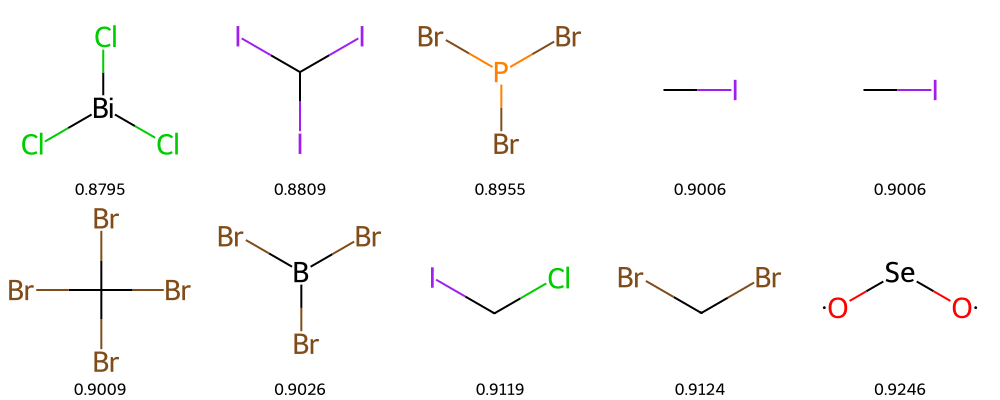

In [26]:
molecules = dataset.SMILES.apply(Chem.MolFromSmiles).to_numpy()
Chem.Draw.MolsToGridImage(
    molecules[indices[:10]],
    molsPerRow=5,
    legends=[str(round(x, 4)) for x in scores[indices[:10]].numpy()]
)



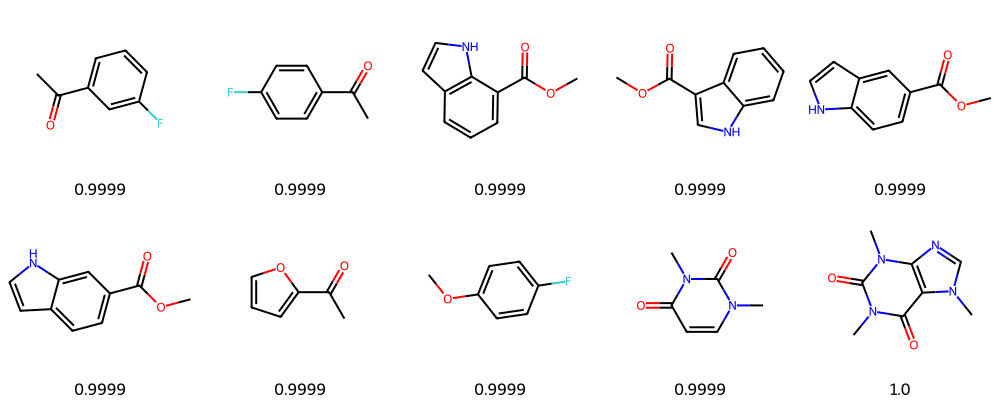

In [27]:
Chem.Draw.MolsToGridImage(
    molecules[indices[-10:]],
    molsPerRow=5,
    legends=[str(round(x, 4)) for x in scores[indices[-10:]].numpy()]
)


## Edge case

GCN cannot distinguish Decalin and Bicyclopentyl graphs as shown below, i.e., two graph-level features are the same. This is generally true for standard **message passing graph nueral networks (MPNNs)**. It is well known that standard MPNNs are as expressive as the 1-WL test, that is, 1-WL test cannot distinguish Decalin and Bicyclopentyl graphs as well.

- WL test(Korean): https://process-mining.tistory.com/170

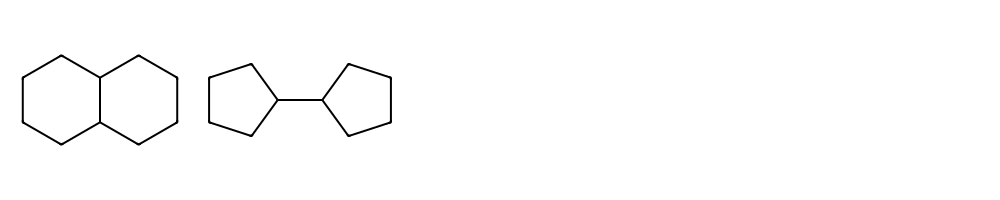

In [28]:
decalin = Chem.MolFromSmiles("C1CCC2CCCCC2C1")
bicyclopentyl  = Chem.MolFromSmiles("C1CCC(C1)C2CCCC2")

Chem.Draw.MolsToGridImage([decalin, bicyclopentyl], molsPerRow=5)

In [29]:
g = gd.Batch.from_data_list([
    from_smiles("C1CCC2CCCCC2C1"),
    from_smiles("C1CCC(C1)C2CCCC2")
])

_, glob = model(g)

# their cosine similarity equals 1.0.
F.cosine_similarity(glob, glob)


tensor([1., 1.], grad_fn=<SumBackward1>)

## References

A lecture from Stanford university.

- https://web.stanford.edu/class/cs224w/

Libraries for AI drug discovery.

- `torchdrug`: https://torchdrug.ai/
- `deepchem`: https://deepchem.io/

## Question


- 각 기호의 의미가 다음과 같다고 하자.

    - $\mathbf{D}$: Degree matrix. `(N, N)` \
        Node degree가 대각선에 위치하고 나머지는 0인 대각행렬이다.
    - $\mathbf{A}$: Adjacency matrix. `(N, N)`
    - $\mathbf{X}$: Node feature matrix. `(N, D)`
    
    이때 아래 수식이 의미하는 바는?

$$
\mathbf{D}^{-1} \mathbf{A} \mathbf{X}
$$
    

- 위에서 우리는 GCN을 전혀 훈련하지 않았다. 그런데도 GCN을 이용해 구한 분자 유사도는 꽤나 정확한 듯하다. 그 이유는 무엇일까?


# 1.3 Genetic algorithm demo

This notebook is a simplified version of https://github.com/aspuru-guzik-group/GA. See Nigam et al., 2020.

In [30]:
import pandas as pd
import selfies as slf
import numpy as np
from rdkit.Chem import Descriptors
from rdkit import Chem
import rdkit
import tqdm
import matplotlib.pyplot as plt
import matplotlib

rdkit.RDLogger.DisableLog('rdApp.*')

print("pandas\t", pd.__version__)
print("numpy\t", np.__version__)
print("rdkit\t", rdkit.__version__)
print("selfies\t", slf.__version__)
print("tqdm\t", tqdm.__version__)
print("matplotlib\t", matplotlib.__version__)

pandas	 1.5.3
numpy	 1.23.5
rdkit	 2023.03.3
selfies	 2.1.0
tqdm	 4.66.1
matplotlib	 3.7.1


In [31]:
# Get dataset
# Tox21 data: Qualitative toxicity measurements on 12 biological targets,
#             including nuclear receptors and stress response pathways [classification]
url = (
    "https://raw.githubusercontent.com/GLambard/Molecules_Dataset_Collection/master/latest/tox21.csv"
)
dataset = pd.read_csv(url)
dataset.head()

,Unnamed: 0,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOC1:C:C:C2:N:C(S(N)(=O)=O):S:C:2:C:1
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3020,CCN1C(=O)NC(C2:C:C:C:C:C:2)C1=O
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX3024,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3027,CCCN(CC)C(CC)C(=O)NC1:C(C):C:C:C:C:1C
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX20800,CC(O)(P(=O)(O)O)P(=O)(O)O


In [32]:
# We will use SELFIES representation for molecules, since it is 100% valid under any perturbations.
# First, we define "alphabet" of the molecules.

# transform to SELFIES
selfies_strings = dataset.smiles.apply(slf.encoder)

# "alphabet" is a set of tokens
alphabet = list(slf.get_alphabet_from_selfies(selfies_strings))

In [33]:
# We will use logP as a fitness score (high logP = high lipophilicity).

def _safe_logP(mol):
    try:
        score = Descriptors.MolLogP(mol)
    except: # invalid molecule
        score = -1
    return score


def evaluate_fitness(selfies):
    fitness = []
    for selfie in selfies:
        smi = slf.decoder(selfie)
        mol = Chem.MolFromSmiles(smi)
        fitness += [_safe_logP(mol)]
    return np.array(fitness)

evaluate_fitness(selfies_strings[:4])

array([1.3424 , 1.2994 , 5.0903 , 3.75244])

In [34]:
# Select molecules to be replaced according to fitness score
# We replace low fitness molecules to mutations of higher fitness molecules.

def select_molecules(fitness):
    # scale rank and pass to sigmoid function
    rank = np.argsort(np.argsort(fitness))
    z = 5 * rank / len(rank) - 2
    probabilities = 1 / (1 + np.exp(-z))

    to_replace = [] # all molecules that are replaced
    to_keep    = [] # all molecules that are kept
    for idx in range(len(rank)):
        if np.random.rand(1) > probabilities[idx]:
            to_replace.append(idx)
        else:
            to_keep.append(idx)
    return to_replace, to_keep

select_molecules([1, 2, 3, 4, 5])

([0, 1, 2], [3, 4])

In [35]:
# Mutation rule: 50% insertions or 50% replacements of single SELFIES characters.

def _is_valid(smi):
    # Although SELFIES is 100% "valid", it includes
    # a "empty molecule" which is not a real substance.
    try:
        mol = Chem.MolFromSmiles(smi, sanitize=True)
        smi = Chem.MolToSmiles(mol, isomericSmiles=False, canonical=True)
        if len(smi) == 0:
            return False
        else:
            return True
    except:
        return False


def random_mutation(selfie, alphabet=alphabet):
    chars_selfie = list(slf.split_selfies(selfie))
    valid = False
    for _ in range(30): # loop until the mutated SELFIES string is valid
        # Insert a character in a Random Location
        if np.random.random() < 0.5:
            random_index = np.random.randint(len(chars_selfie)+1)
            random_character = np.random.choice(alphabet, size=1)[0]

            selfie_mutated_chars = chars_selfie[:random_index] + [random_character] + chars_selfie[random_index:]

        # Replace a random character
        else:
            random_index = np.random.randint(len(chars_selfie))
            random_character = np.random.choice(alphabet, size=1)[0]
            selfie_mutated_chars = chars_selfie[:random_index] + [random_character] + chars_selfie[random_index+1:]

        selfie_mutated = ''.join(selfie_mutated_chars)
        smiles = slf.decoder(selfie_mutated)
        if _is_valid(smiles):
            break

    return selfie_mutated


def replace_next_gen_molecules(population, to_replace, to_keep):
    for idx in to_replace:
        # smiles to replace (by better molecules)
        random_index=np.random.choice(to_keep, size=1)[0]    # select a random molecule that survived
        population[idx] = random_mutation(population[random_index])  # do the mutation (inplace)
    return population

selfie = selfies_strings[19]

print("original", selfie)
print("mutated ", random_mutation(selfie, alphabet))

original [C][C][O][C][=Branch1][C][=O][C][=C][C][=C][N][=C][Ring1][=Branch1]
mutated  [C][C][O][C][=Branch1][Ag+1][=O][C][=C][C][=C][N][=C][Ring1][=Branch1]


100%|██████████| 50/50 [01:41<00:00,  2.03s/it, fitness=26]


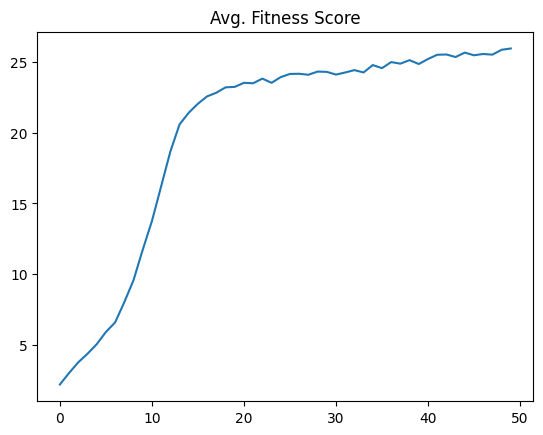

In [36]:
# population size: 500
population = dataset.smiles[:500].apply(slf.encoder).to_list()

avg_fit = []
pbar = tqdm.trange(50)

for _ in pbar:
    fitness = evaluate_fitness(population)
    to_replace, to_keep = select_molecules(fitness)
    population = replace_next_gen_molecules(population, to_replace, to_keep)

    avg_fit.append(np.mean(fitness))
    pbar.set_postfix({"fitness": avg_fit[-1]})

plt.title("Avg. Fitness Score")
plt.plot(avg_fit)
plt.show()

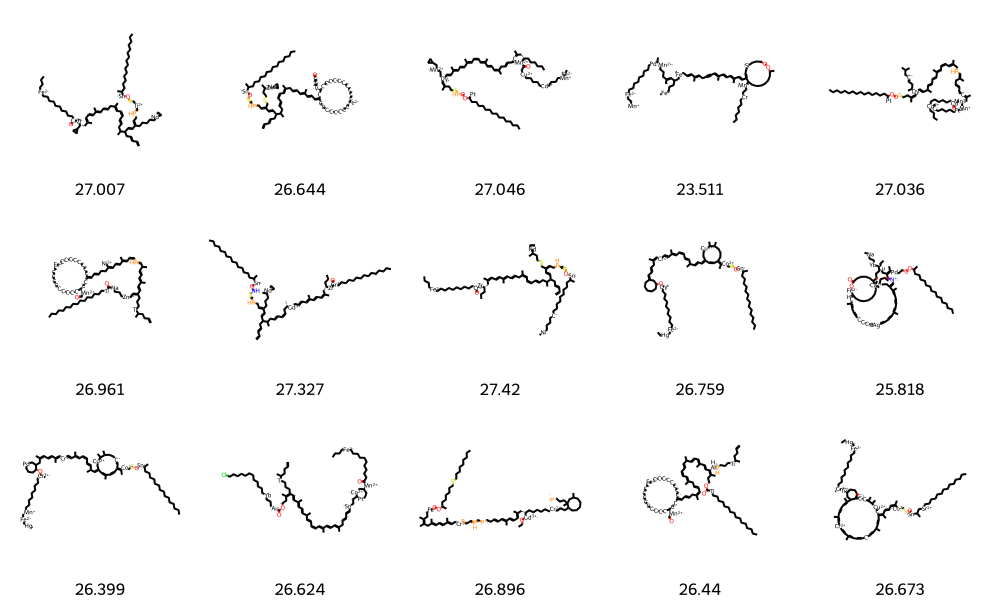

In [37]:
# Note that logP can be optimized without bound, which can result in unrealistic molecules.
smiles = [slf.decoder(selfie) for selfie in population]
mols = [Chem.MolFromSmiles(smi) for smi in smiles]
legends = [str(round(x, 3)) for x in evaluate_fitness(population[:24])]

Chem.Draw.MolsToGridImage(mols[:15], molsPerRow=5, legends=legends)

## References

Nigam et al., "Augmenting genetic algorithms with deep neural networks for exploring the chemical space", ICLR, 2020.

# 2.1 Gumbel-max trick

In [38]:
import torch_scatter
from torch_scatter import scatter_log_softmax, scatter_max, scatter_sum


import torch_geometric
import torch_geometric.data as gd
import torch_geometric.nn as gnn
from torch_geometric.utils import from_smiles

import torch
from torch.distributions import Categorical
import torch.nn as nn

print("torch\t", torch.__version__)
print("torch_scatter\t", torch_scatter.__version__)
print("torch_geometric\t", torch_geometric.__version__)

torch	 2.0.1+cu118
torch_scatter	 2.1.1+pt20cu118
torch_geometric	 2.3.1


## Scatter operation using `torch_scatter`


Unlike images, text and audio, graphs usually have irregular structures, which makes them hard to batch in tensor frameworks. Many existing implementations use padding to convert graphs into dense grid structures, which costs much unnecessary computation and memory.


With `torch_scatter`, this notebook will show how we can deal with variadic inputs.


See the figure below to see how `torch_scatter` works.


<img width="50%" src="https://raw.githubusercontent.com/rusty1s/pytorch_scatter/master/docs/source/_figures/add.svg?sanitize=true" style="background-color:white;padding:20px;">

In [39]:
import torch
from torch_scatter import scatter_sum

index  = torch.LongTensor([0,0,1,0,2,2,3,3])
input_ = torch.LongTensor([5,1,7,2,3,2,1,3])

output = scatter_sum(input_, index)
output

tensor([8, 7, 5, 4])

In [40]:
# torch_geometric.nn.global_add_pool gives the same functionality

gnn.global_add_pool(input_, index)

tensor([8, 7, 5, 4])

## Variable-sized logits

In [41]:

class GCNPolicy(nn.Module):
    def __init__(self, input_dim, emb_dim=64):
        super().__init__()
        self.conv1 = gnn.GCNConv(input_dim, emb_dim)
        self.conv2 = gnn.GCNConv(emb_dim, emb_dim)

        self.glob_mlp = nn.Linear(emb_dim, 1)
        self.node_mlp = nn.Linear(emb_dim, 1)
        self.edge_mlp = nn.Linear(emb_dim, 1)

    def logits(self, g):
        x, edge_index = g.x.float(), g.edge_index
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        glob = gnn.global_add_pool(x, g.batch)

        i, j = edge_index
        edge_feature = x[i] + x[j]

        glob_logits = self.glob_mlp(glob).flatten()
        node_logits = self.node_mlp(x).flatten()
        edge_logits = self.edge_mlp(edge_feature).flatten()

        logits = torch.cat([glob_logits, node_logits, edge_logits])
        return logits


d1 = from_smiles("CN1C=NC2=C1C(=O)N(C(=O)N2C)C") # caffeine
d2 = from_smiles("CC(=O)NC1=CC=C(C=C1)O") # acetaminophen

data_list = [d1, d2]
g = gd.Batch.from_data_list(data_list)
g.num_edges = torch.LongTensor([d.num_edges for d in data_list])


gcn = GCNPolicy(g.x.shape[1])
logits = gcn.logits(g)

logits.shape

torch.Size([79])

In [42]:
glob_batch = torch.arange(g.num_graphs)
node_batch = g.batch
edge_batch = torch.repeat_interleave(g.num_edges)

indices = torch.cat([glob_batch, node_batch, edge_batch])


indices

tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1])

In [43]:
# We can calculate log probabilities for each logit using scatter_log_softmax.
# But how can we get target probabilities that correspond to labels?

y = torch.LongTensor([2, 13])
scatter_log_softmax(logits, indices)

tensor([-14.0930, -11.6527,  -4.5997,  -4.5256,  -4.5712,  -4.5750,  -4.5510,
         -4.5462,  -4.5379,  -4.6011,  -4.5225,  -4.5325,  -4.5955,  -4.5256,
         -4.6048,  -4.6048,  -4.2941,  -4.2232,  -4.3171,  -4.2627,  -4.2196,
         -4.2482,  -4.2420,  -4.1956,  -4.2420,  -4.2482,  -4.2757,  -3.5918,
         -3.5918,  -3.5441,  -3.4822,  -3.5441,  -3.6724,  -3.6724,  -3.6119,
         -3.6119,  -3.5283,  -3.4904,  -3.4822,  -3.5283,  -3.5194,  -3.5194,
         -3.6906,  -3.4792,  -3.6906,  -3.4792,  -3.4647,  -3.6044,  -3.4647,
         -3.6759,  -3.4671,  -3.6759,  -3.4904,  -3.4671,  -3.6068,  -3.6068,
         -3.6044,  -3.2409,  -3.2409,  -3.2994,  -3.1937,  -3.2994,  -3.1937,
         -3.2320,  -3.2320,  -3.2467,  -3.2467,  -3.2467,  -3.3230,  -3.3230,
         -3.2295,  -3.2295,  -3.2295,  -3.3229,  -3.2295,  -3.3230,  -3.2467,
         -3.3230,  -3.3229], grad_fn=<SubBackward0>)

In [44]:
# We first sort the indices and logits
sorted_indices, mapping = torch.sort(indices, stable=True)
sorted_logits = logits[mapping]

sorted_indices

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1])

In [45]:
# We get target probabilities by adjusting indices
count = torch.bincount(sorted_indices)
offsets = torch.cumsum(count, 0) - count

y + offsets

tensor([ 2, 58])

In [46]:
log_probs = scatter_log_softmax(sorted_logits, sorted_indices)
log_probs[y + offsets]

tensor([-4.5256, -3.2409], grad_fn=<IndexBackward0>)

## Gumbel-max trick

Suppose we would like to obtain samples from multiple multinomial distributions, parameters given by variable-sized logits.

We can sample without even calculating softmax using Gumbel-max trick.

```
u ~ uniform(len(logits))
X ~ argmax(logits -log(-log(u)))
```

The noise added to logits, `-log(-log(u))`, follows Gumbel distribution, which gives the name.

*Note*

CDF of Gumbel distribution:

$$
F(x) = \exp\{- \exp\{-x\}\}.
$$

Inverse CDF of Gumbel distribution:

$$
F^{-1}(y) = -\log(-\log y).
$$



Proof: https://lips.cs.princeton.edu/the-gumbel-max-trick-for-discrete-distributions/

In [47]:
# We can sample from logits using Gumbel-max trick

logits = torch.FloatTensor([0, 1, 10, 2, 1, 0])
indices = torch.LongTensor([1, 1,  1, 1, 0,  0])


indices, mapping = torch.sort(indices, stable=True)
logits = logits[mapping]

unif = torch.rand_like(logits)
gumbel = -(-unif.log()).log()
_, max_indices = scatter_max(logits + gumbel, indices)

count = torch.bincount(indices)
offsets = torch.cumsum(count, 0) - count
samples =  max_indices - offsets

samples

tensor([0, 2])

## References

- Jang et al., "Categorical reparameterization with gumbel-softmax", ICLR, 2017.

- Maddison et al., "The concrete distribution: A continuous relaxation of discrete random variables", ICLR, 2017.

## Question
    
1. `torch.rand_like(logits)`와 `torch.rand(len(logits))`와의 차이는??

# 2.2 Score function estimator

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

print("numpy\t", np.__version__)
print("matplotlib\t", matplotlib.__version__)

numpy	 1.26.0
matplotlib	 3.8.0


In [ ]:
class Sampler:
    def __init__(self):
        self.mu = np.ones(2)
        self.const = - np.log(2 * np.pi)

    def sample(self, n_samples=1):
        return np.random.randn(n_samples, 2) + self.mu

    def log_prob(self, x):
        return - 0.5 * ((x - self.mu)**2).sum(1) + self.const

    def grad_log_prob(self, x):
        return x - self.mu

sampler = Sampler()
x = sampler.sample(3)
x

array([[ 2.57690706,  2.44616046],
       [-0.3691759 ,  1.04371578],
       [-0.62622906,  1.51940807]])

In [ ]:
np.exp(sampler.log_prob(x))

array([0.01613305, 0.06227757, 0.03706508])

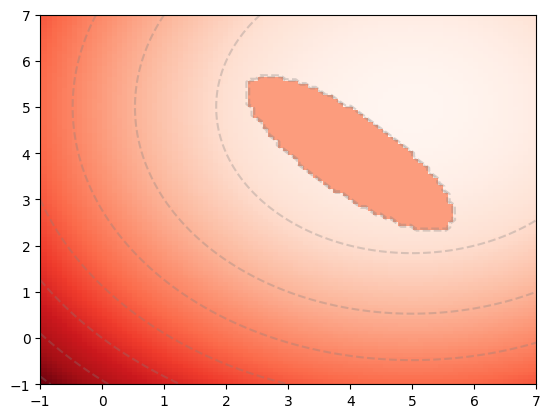

In [ ]:
def reward_function(samples):
    target = np.array([5., 5.])
    obstacle = np.array([4., 4.])
    rewards = - ((samples - target)**2).sum(1)
    diff = samples - obstacle
    dist = ((diff @ np.array([[1, 0.8], [0.8, 1]]) ) * diff).sum(1)
    rewards[dist < 1] = - 25
    return rewards

def reward_landscape(reward_func):
    x, y = np.meshgrid(np.linspace(-1, 7, 100), np.linspace(-1, 7, 100))
    x_coo, y_coo = x.flatten(), y.flatten()
    rewards = reward_func(np.stack([x_coo, y_coo]).T)

    plt.pcolor(x, y, rewards.reshape(*x.shape), cmap=plt.get_cmap("Reds_r"))
    plt.contour(x, y, rewards.reshape(*x.shape), colors='gray', alpha=0.3)
    plt.xlim([-1, 7])
    plt.ylim([-1, 7])

reward_landscape(reward_function)

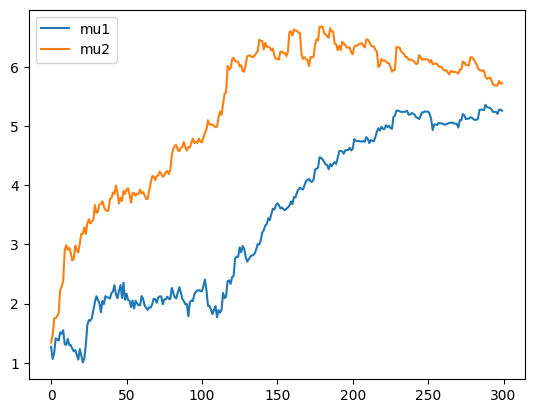

In [ ]:
lr = 0.01
sampler = Sampler()

mus = []
for _ in range(300):
    samples = sampler.sample(3)
    rewards = reward_function(samples)
    grad_log_probs = sampler.grad_log_prob(samples)
    grad = np.mean(grad_log_probs * rewards[:, None], axis=0)

    sampler.mu = sampler.mu + lr * grad  #gradient_ascent
    mus.append(sampler.mu)


mu1, mu2 = np.stack(mus).T


plt.plot(mu1, label='mu1')
plt.plot(mu2, label='mu2')
plt.legend()
plt.show()

In [ ]:
def plot(traces, grad_steps, mu, target):
    plt.figure(figsize=(5, 5))
    plt.title(f"Update: {i + 1}")
    reward_landscape(reward_function)

    plt.plot(*traces.T, c='c', linewidth=0.8)

    for g in grad_steps:
        plt.arrow(*mu, *g, head_width=.1, head_length=.1, fc='k', ec='k')

    plt.scatter(*samples.T, s=10, marker='x')
    plt.scatter(*mu, c='c')

    plt.scatter(*target, c='y')
    plt.text(*target, "goal")
    plt.show()

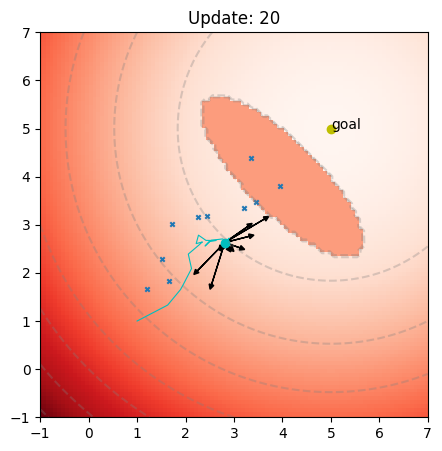

In [ ]:
from IPython import display
import time

lr = 0.02
n_samples = 10
sampler = Sampler()
target = np.array([5., 5.])

traces = np.array([]).reshape(0, 2)

for i in range(20):
    samples = sampler.sample(n_samples)
    rewards = reward_function(samples)
    grad_log_probs = sampler.grad_log_prob(samples)
    grad_steps = lr * grad_log_probs * rewards[:, None]

    traces = np.concatenate([traces, sampler.mu[None, :]], axis=0)
    plot(traces, grad_steps, sampler.mu, target)

    sampler.mu = sampler.mu + np.mean(grad_steps, axis=0)  #gradient_ascent


    time.sleep(0.1)
    display.clear_output(wait=True)


# 2.3 Environment

In [ ]:
import enum
from dataclasses import dataclass, field

## State & action spaces


**State space**

- A state is simply a graph with node types and edge types
- We define initial state as a graph with one node.

**Action space**

- AddNode: add a new node
- AddEdge: add a new edge
- Stop: end the episode

In [ ]:
class NodeType(enum.Enum):
    C = enum.auto()
    N = enum.auto()
    O = enum.auto()
    S = enum.auto()
    P = enum.auto()
    F = enum.auto()
    I = enum.auto()
    Cl = enum.auto()
    Br = enum.auto()



class EdgeType(enum.Enum):
    SINGLE = enum.auto()
    DOUBLE = enum.auto()
    TRIPLE = enum.auto()



class ActionType(enum.Enum):
    AddNode = enum.auto()
    AddEdge = enum.auto()
    STOP = enum.auto()


@dataclass
class State:
    node_types: list[NodeType] = field(default_factory=list)
    edge_types: list[EdgeType] = field(default_factory=list)
    edge_list: list[tuple[int, int]] = field(default_factory=list)

    num_node: int = field(default_factory=int, repr=False)
    num_edge: int = field(default_factory=int, repr=False)
    _edge_set: set[tuple[int, int]] = field(default_factory=set, repr=False)

    def __post_init__(self):
        self.num_node = len(self.node_types)
        self.num_edges = len(self.edge_types)
        self._edge_set = set(self.edge_list)

    def add_node(self, node_type: NodeType):
        self.node_types.append(node_type)
        self.num_node += 1

    def add_edge(self, i: int, j: int, edge_type: EdgeType):
        edge = (i, j) if i < j else (j, i)
        self.edge_types.append(edge_type)
        self.edge_list.append(edge)
        self._edge_set.add(edge)
        self.num_edge += 1

@dataclass
class Action:
    type: ActionType = None
    source: int = None
    target: int = None
    node_type: NodeType = None
    edge_type: EdgeType = None


class Trajectory:
    def __init__(self, states, actions):
        assert len(states) == len(actions)
        self.states = states
        self.actions = actions

    @property
    def last_state(self):
        return self.states[-1]

    def __len__(self):
        return len(self.states)

    def __repr__(self):
        return f"{self.__class__.__name__}(size: {len(self)})"


## `mol_env.py`

This part of implementation is bit complicated, so you may just import `mol_env` and use it.

In [50]:
import mol_env as env

state = env.initial_state()
state

State(node_types=[C], edge_types=[], edge_list=[])

In [51]:
action = env.Action(
    type=env.ActionType.AddNode,
    node_type=env.NodeType.N
)
env.step(state, action)

(State(node_types=[C, N], edge_types=[], edge_list=[]), False)

In [52]:
caffeine = "CN1C=NC2=C1C(=O)N(C(=O)N2C)C"
state = env.State.from_smiles(caffeine)
state

State(node_types=[C, N, C, N, C, C, C, O, N, C, O, N, C, C], edge_types=[SINGLE, SINGLE, DOUBLE, SINGLE, DOUBLE, SINGLE, DOUBLE, SINGLE, SINGLE, DOUBLE, SINGLE, SINGLE, SINGLE, SINGLE, SINGLE], edge_list=[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (6, 8), (8, 9), (9, 10), (9, 11), (11, 12), (8, 13), (5, 1), (11, 4)])

In [53]:
env.to_Data(state)

Data(edge_index=[2, 30], non_edge_index=[2, 78], node_type=[14], edge_type=[30], num_non_edges=78)

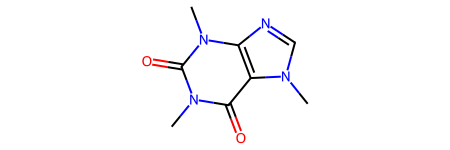

In [54]:
state.to_mol()

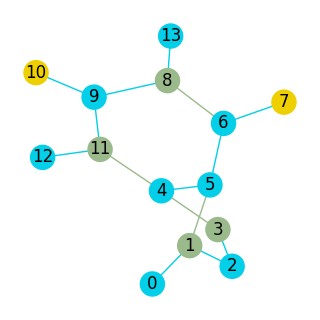

In [55]:
state.viz()

In [56]:
traj = env.get_bfs_trajectory(state)
traj

Trajectory(size: 29)

In [57]:
traj.states[:6]

[State(node_types=[C], edge_types=[], edge_list=[]),
 State(node_types=[C, N], edge_types=[], edge_list=[]),
 State(node_types=[C, N], edge_types=[SINGLE], edge_list=[(0, 1)]),
 State(node_types=[C, N, C], edge_types=[SINGLE], edge_list=[(0, 1)]),
 State(node_types=[C, N, C], edge_types=[SINGLE, SINGLE], edge_list=[(0, 1), (1, 2)]),
 State(node_types=[C, N, C, C], edge_types=[SINGLE, SINGLE], edge_list=[(0, 1), (1, 2)])]

In [58]:
traj.last_state

State(node_types=[C, N, C, C, N, C, C, N, O, N, C, C, C, O], edge_types=[SINGLE, SINGLE, SINGLE, DOUBLE, DOUBLE, SINGLE, SINGLE, SINGLE, DOUBLE, SINGLE, SINGLE, SINGLE, SINGLE, SINGLE, DOUBLE], edge_list=[(0, 1), (1, 2), (1, 3), (2, 4), (3, 5), (3, 6), (4, 5), (5, 7), (6, 8), (6, 9), (7, 10), (7, 11), (9, 10), (9, 12), (10, 13)])

# 2.4 Molecule generation using RL demo

In [59]:
# torch_geometric
import torch_geometric
import torch_geometric.nn as gnn
import torch_geometric.data as gd

# torch
import torch
from torch import nn
import torch.nn.functional as F

# rdkit
import rdkit
from rdkit import Chem

# ML related
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import tqdm


# custom library
import mol_env as env
from models import MLP, RGCN
from distributions import ActionCategorical

# check version
print("torch_geometric\t", torch_geometric.__version__)
print("torch\t", torch.__version__)
print("pandas\t", pd.__version__)
print("rdkit\t", rdkit.__version__)
print("matplotlib\t", matplotlib.__version__)
print("tqdm\t", tqdm.__version__)
print("networkx\t", nx.__version__)

torch_geometric	 2.3.1
torch	 2.0.1+cu118
pandas	 1.5.3
rdkit	 2023.03.3
matplotlib	 3.7.1
tqdm	 4.66.1
networkx	 3.1


## Define a Model

We extract node- and graph-level features using GCN. Then we compute logit values for each action.

- Stop: calculated based on graph features.
- AddNode: calculated based on graph features.
- AddEdge: calculated based on two node features to be connected (similar to link prediction).

In [ ]:

class Policy(nn.Module):
    def __init__(self, num_node_types, num_edge_types, emb_dim=32, num_layers=3, activation="leaky_relu"):
        super().__init__()
        self.num_node_types = num_node_types
        self.num_edge_types = num_edge_types
        self.graph_nn = RGCN(num_node_types, num_edge_types, emb_dim=emb_dim, num_layers=num_layers)
        self.stop_mlp = MLP([emb_dim, emb_dim, 1], activation)
        self.addnode_mlp = MLP([emb_dim, emb_dim, num_node_types], activation)
        self.addedge_mlp = MLP([emb_dim, emb_dim, emb_dim, num_edge_types], activation)
        self.activation = getattr(F, activation)

    def logits(self, g):
        x = self.graph_nn(g)
        graph_features = gnn.global_add_pool(x, g.batch)

        i, j = g.non_edge_index
        non_edge_features = x[i] + x[j]

        stop_logits = self.stop_mlp(graph_features).flatten()
        addnode_logits = self.addnode_mlp(graph_features).flatten()
        addedge_logits = self.addedge_mlp(non_edge_features).flatten()
        logits = [stop_logits, addnode_logits, addedge_logits]
        return torch.cat(logits, dim=0)

    def forward(self, states):
        g = self.collate(states)
        logits = self.logits(g)
        stop_batch = torch.arange(g.num_graphs)
        addnode_batch = torch.arange(g.num_graphs).repeat_interleave(self.num_node_types)
        addedge_batch = torch.repeat_interleave(self.num_edge_types * g.num_non_edges)
        indices = torch.cat([stop_batch, addnode_batch, addedge_batch], dim=0)
        return ActionCategorical(states, logits, indices)

    def collate(self, states):
        return gd.Batch.from_data_list(
            [env.to_Data(s) for s in states]
        )



# sample data
caffeine = "CN1C=NC2=C1C(=O)N(C(=O)N2C)C"
state = env.State.from_smiles(caffeine)
traj = env.get_bfs_trajectory(state)


# Model
model = Policy(env.num_node_types, env.num_edge_types, emb_dim=32, num_layers=3)
cat = model(traj.states)
cat

ActionCategorical(size=29)

In [ ]:
cat.log_prob(traj.actions)

tensor([ -2.4442,  -2.7075,  -2.5722,  -2.8552,  -3.4012,  -3.0843,  -3.3883,
         -3.8011,  -4.1866,  -4.0660,  -4.2265,  -4.2201,  -4.1138,  -4.5701,
         -4.7693,  -6.5081,  -5.1335,  -6.0265,  -5.2454,  -3.5483,  -5.3969,
         -4.0391,  -5.5428,  -5.8665,  -5.2632,  -6.1691, -10.0930,  -6.6618,
        -12.4662], grad_fn=<IndexBackward0>)

## Sampler

In [ ]:
@torch.no_grad()
def sample_trajectory(env, model, max_len=25):
    model.eval()
    states, actions = [], []
    state = env.initial_state()
    for _ in range(max_len):
        cat = model([state])
        action = cat.sample()[0]
        next_state, done = env.step(state, action)

        states.append(state)
        actions.append(action)

        state = next_state
        if done:
            break

    return env.Trajectory(states, actions)


def sample_trajectories(env, model, n_samples, max_len=25):
    not_done = np.ones(n_samples, dtype=bool)
    states = [env.initial_state() for _ in range(n_samples)]
    trajectories = [[] for _ in range(n_samples)]
    for _ in range(max_len):
        actions = model(states).sample()
        nz = not_done.nonzero()[0]
        next_states = []
        for i, state, action in zip(nz, states, actions):
            next_state, done = env.step(state, action)

            if not done:
                next_states.append(next_state)
            else:
                not_done[i] = False

            trajectories[i].extend([state, action])

        if any(not_done):
            states = next_states
        else:
            break

    trajectories = [env.Trajectory(t[::2], t[1::2]) for t in trajectories]
    return trajectories

trajs = sample_trajectories(env, model, n_samples=3)
trajs

[Trajectory(size: 25), Trajectory(size: 1), Trajectory(size: 22)]

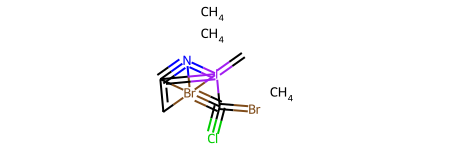

In [ ]:
trajs[0].last_state.to_mol()

## Maximum-likelihood Training

In [ ]:
url = 'https://raw.githubusercontent.com/gashawmg/HOMO-LUMO-Enegry-gap-Prediction/master/Orbital_Energies_input_data.csv'
dataset = pd.read_csv(url)
molecules = dataset.SMILES.apply(Chem.MolFromSmiles).tolist()

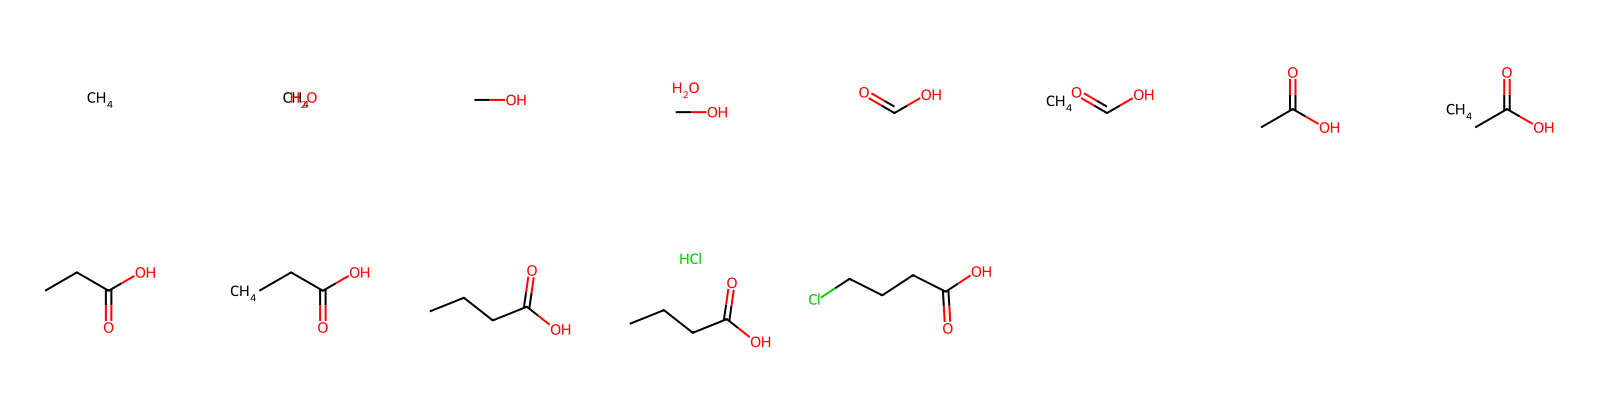

In [ ]:
# We will use only two samples to see if this works

mol_state0 = env.State.from_mol(molecules[0])
mol_state1 = env.State.from_mol(molecules[1])
traj0 = env.get_bfs_trajectory(mol_state0)
traj1 = env.get_bfs_trajectory(mol_state1)

states = traj0.states + traj1.states
actions = traj0.actions + traj1.actions

Chem.Draw.MolsToGridImage([s.to_mol() for s in traj1.states], molsPerRow=8)

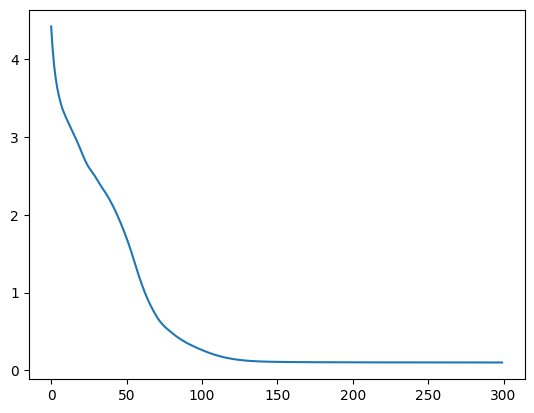

In [ ]:
# overfit
model = Policy(env.num_node_types, env.num_edge_types, emb_dim=32, num_layers=3)
optimizer = torch.optim.Adam(model.parameters())

losses = []
for _ in range(300):
    cat = model(states)
    loss = -cat.log_prob(actions).mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())


plt.plot(losses)
plt.show()

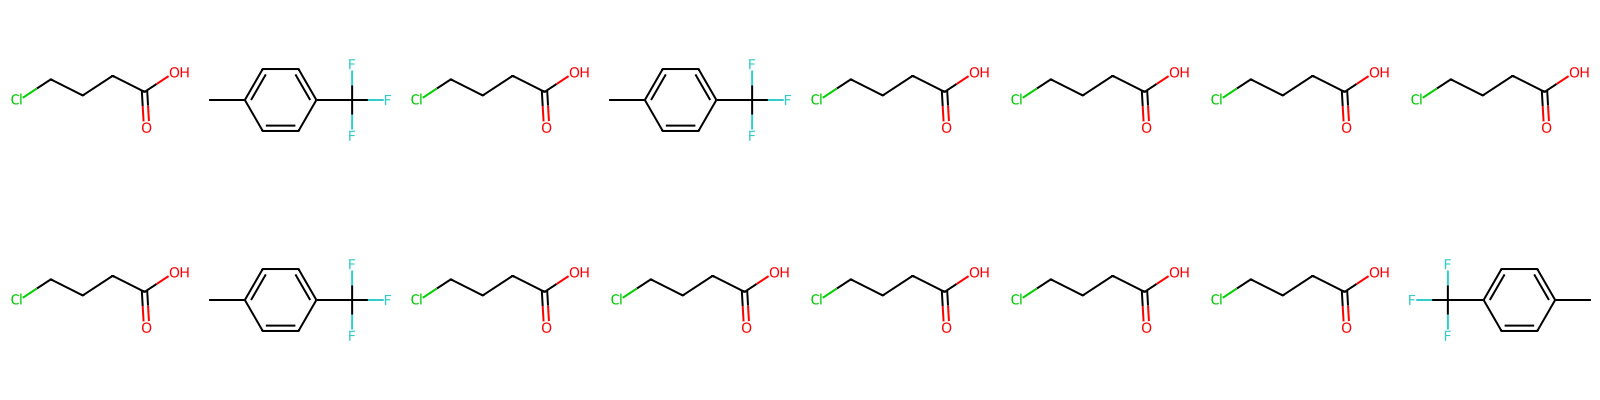

In [ ]:

trajs = sample_trajectories(env, model, n_samples=16)
samples = [t.last_state.to_mol() for t in trajs]

Chem.Draw.MolsToGridImage(samples, molsPerRow=8)

In [ ]:
# preprocess data
all_states = []
for m in molecules:
    try:
        all_states += [env.State.from_mol(m)]
    except:
        pass

100%|███████████████████████████████| 200/200 [00:19<00:00, 10.06it/s, loss=0.868]


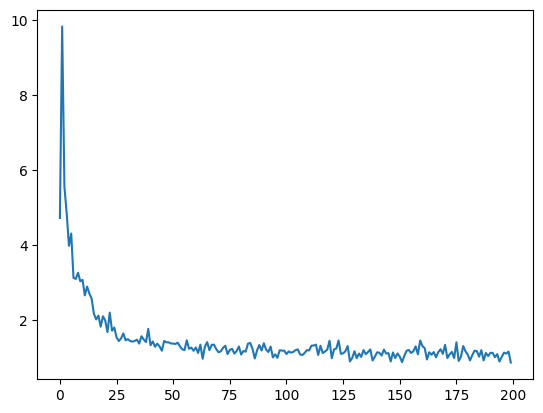

In [ ]:
# train on full data

batch_size = 16
model = Policy(env.num_node_types, env.num_edge_types, emb_dim=256, num_layers=3)
optimizer = torch.optim.Adam(model.parameters())

losses = []
pbar = tqdm.trange(200)
for _ in pbar:
    minibatch = np.random.choice(all_states, size=batch_size)
    trajs = [env.get_bfs_trajectory(s) for s in minibatch]

    states = sum([t.states for t in trajs], [])
    actions = sum([t.actions for t in trajs], [])

    cat = model(states)
    loss = -cat.log_prob(actions).mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    pbar.set_postfix({"loss":loss.item()})


plt.plot(losses)
plt.show()

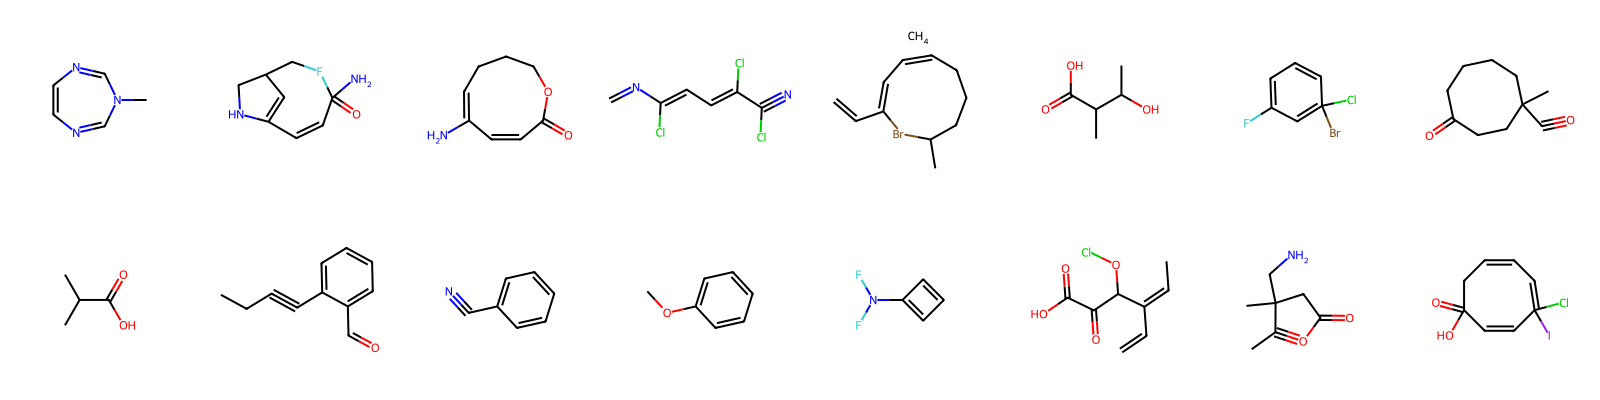

In [ ]:

trajs = sample_trajectories(env, model, n_samples=16)
samples = [t.last_state.to_mol() for t in trajs]

Chem.Draw.MolsToGridImage(samples, molsPerRow=8)

## Score function estimator (REINFORCE)


In [ ]:
def reward_func(state):
    reward = 0.0

    # +0.5 for oxygen
    for u in state.node_types:
        if u == env.NodeType.O:
            reward += 0.5

    # -0.2 for SINGLE
    # -0.4 for DOUBLE, -0.6 for TRIPLE bond
    for e in state.edge_types:
        reward -= 0.2 * e.value

    # -1 reward for connected components
    G = nx.from_edgelist(state.edge_list)
    G.add_nodes_from(np.arange(len(state.node_types)))
    reward -= nx.number_connected_components(G)
    return reward


traj = sample_trajectory(env, model)
reward_func(traj.last_state)

-3.1999999999999997

In [ ]:
def get_trajectory_log_probs(model, trajectories):
    model.train()
    states = sum([t.states for t in trajectories], [])
    actions = sum([t.actions for t in trajectories], [])
    state_log_probs = model(states).log_prob(actions)

    sizes = torch.LongTensor([len(t) for t in trajectories])
    batch = torch.repeat_interleave(sizes)
    traj_log_probs = gnn.global_add_pool(state_log_probs, batch)
    return traj_log_probs

trajectories = sample_trajectories(env, model, n_samples=5)
get_trajectory_log_probs(model, trajectories)

tensor([-17.4064, -16.5894, -17.4662, -11.8478, -28.6176],
       grad_fn=<ScatterAddBackward0>)

100%|███████████████████████████| 300/300 [00:13<00:00, 22.54it/s, avg_reward=2.6]


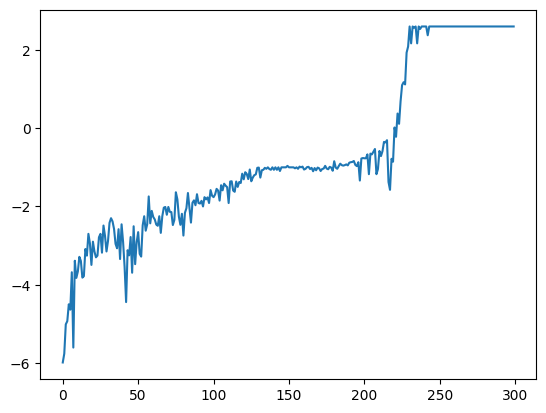

In [ ]:
batch_size = 16

# torch.manual_seed(0)
model = Policy(env.num_node_types, env.num_edge_types, emb_dim=32, num_layers=3)
optimizer = torch.optim.Adam(model.parameters())

avg_rewards = []
pbar = tqdm.trange(300)
for _ in pbar:
    trajectories = sample_trajectories(env, model, batch_size)
    log_probs = get_trajectory_log_probs(model, trajectories)
    rewards = torch.tensor(
        [reward_func(t.last_state) for t in trajectories]).float()

    loss = torch.mean(- log_probs * rewards)
    optimizer.zero_grad()
    loss.backward()

    nn.utils.clip_grad_norm_(
        model.parameters(), 0.5)
    optimizer.step()

    avg_rewards.append(rewards.mean().item())

    pbar.set_postfix({"avg_reward": avg_rewards[-1]})


plt.plot(avg_rewards)
plt.show()

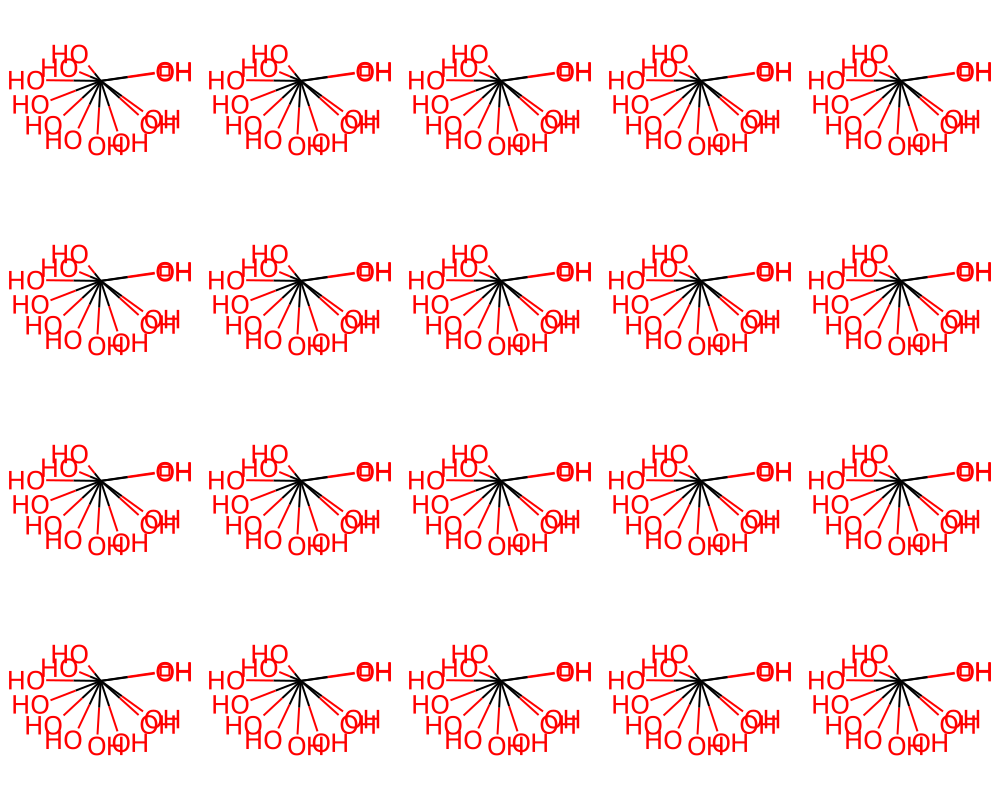

In [ ]:
trajs = sample_trajectories(env, model, 20)
samples = [t.last_state.to_mol() for t in trajs]

Chem.Draw.MolsToGridImage(samples, molsPerRow=5)